# Graph Neural Network test teacher

## Importing

In [1]:
import sys
sys.path.append('../')

In [2]:
from selfdist_toolkit.pyg_tools import gnn_load, GIN_nn, execution, sd_utils, accuracy
import pandas as pd
import torch
import torch_geometric
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

C:\Users\johan\anaconda3\envs\praktikum\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data loading (aid list)

In [3]:
aid_list = pd.read_csv("../results/random_forest/experiments_check/chem-desc_good-aid_1.csv").aid.to_numpy().astype(int)

In [4]:
aid_list

array([    884,     891,     899,     914,    1418,    1431,    1770,
          1771,    1795,  493073,  493102,  493177,  493191,  493240,
        588834,  651741,  651812,  651814,  686978,  687022,  720691,
        743036,  743040,  743065, 1053173, 1259381, 1346982])

## Data loading (all molecules for self distillation)

In [5]:
# get list of all molecules as pyg elements
all_molec_list = gnn_load.load_all_pyg(path_data="../data/")

In [6]:
# load all the smiles as string list
all_smiles = np.array([mol.smiles for mol in all_molec_list], dtype=str)

## Procedure environment setting

In [7]:
# number epochs
epochs = 3000

In [8]:
# random state where we want to set it
random_state = 131313

In [9]:
# hard mode - soft mode is actually deprecated
mode = "hard"

In [10]:
# batch size
batch_size=100

## Setting up storage location

In [11]:
# path for csv dataframe
csv_path = "../results/teacher_exp_ulong/csv/"
# path for graphs
graphs_path = "../results/teacher_exp_ulong/graphs/"
# path for self distillation output
sd_path = "../results/teacher_exp_ulong/sd_out/"

In [12]:
# make sure the folder exists
if not os.path.exists(csv_path):
    os.makedirs(csv_path)
if not os.path.exists(graphs_path):
    os.makedirs(graphs_path)
if not os.path.exists(sd_path):
    os.makedirs(sd_path)

## Iteration over assay ids and execution of procedure

In [13]:
aid = 884

In [14]:
# =================================================
# Load data
# =================================================
# load data for experiment
whole_data = gnn_load.load_pyg_data_aid(aid=aid, label_type=mode, do_in_parallel=True, path_data="../data/")

# get hard labels
labels_hard = np.array([
    data.y.detach().cpu().numpy()
    for data in whole_data
]).flatten().astype(int)

# do data splitting in train and test 80:20
# data splitting
for train_idx, test_idx in StratifiedShuffleSplit(n_splits=1, random_state=random_state, test_size=0.2).split(whole_data, labels_hard):
    break

# generate the dataloader
dl_train = torch_geometric.loader.DataLoader([whole_data[idx] for idx in train_idx], batch_size=batch_size)
dl_test = torch_geometric.loader.DataLoader([whole_data[idx] for idx in test_idx], batch_size=batch_size)

In [15]:
# =================================================
# Model setup
# =================================================
# GNN model
model = GIN_nn.GIN_basic(1)
# loss
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([len(train_idx)/labels_hard[train_idx].sum()]))
# device
device = torch.device('cuda')
model = model.to(device)
loss = loss.to(device)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
# =================================================
# Epoch iteration
# =================================================
# define loss saving space
loss_storage = []

# define accuracy storage
accuracy_storage = []

# epoch iterations
for epoch in tqdm(range(epochs)):

    # do training step
    loss_value = execution.training(model, dl_train, device, optimizer, loss, verbose=False)

    # put loss into storage
    loss_storage.append(loss_value)

    # do testing step
    y_pred_hard = execution.predict(model, dl_test, device, reduce_to_hard_label=True, verbose=False)

    # calculate accuracy DataFrame
    accuracy_storage.append(
        # get accuracy class and from it the DataFrame
        accuracy.calculate_accuracies_1d(
            y_pred=y_pred_hard, 
            y_true=accuracy.helper_pyg_to_numpy_label(
                data_loader=dl_test
            )
        ).to_df(index=epoch)
    )

# transform accuracy storage to pandas df
accuracy_storage = pd.concat(accuracy_storage)

# add new column for loss
accuracy_storage['loss'] = loss_storage

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [2:36:24<00:00,  3.13s/it]


In [17]:
# =================================================
# Save data to file
# =================================================
# set file path
file_path = csv_path + "teacher-acc_aid={}_epochs={}.csv".format(aid, epochs)

# write to file
accuracy_storage.to_csv(file_path, index=True, index_label="epoch")

In [18]:
# =================================================
# Self distillation calculate accuracy of all other molecules
# =================================================
# get the aid smiles
aid_smiles = gnn_load.load_pure_data(aid, path_data="../data/").smiles.to_numpy().astype(str)

# get index of elements where the elements are not the same (new elements)
idx = np.where(np.invert(np.in1d(all_smiles, aid_smiles)))[0].tolist()

# get the items which are new
molec_list = list(map(all_molec_list.__getitem__, idx))
dl_sd = torch_geometric.loader.DataLoader(molec_list, batch_size=batch_size)

# get prediction
sd_pred = execution.predict(model, dl_sd, device, reduce_to_hard_label=False, verbose=True)

# create Dataframe and save it
sd_file_path = sd_path + "teacher-pred_aid={}_epochs={}.csv".format(aid, epochs)
pd.DataFrame({
    "smiles": list(map(lambda x: x.smiles, molec_list)),
    "predicted_label_soft": sd_pred
}).to_csv(sd_file_path, index=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4455/4455 [00:58<00:00, 76.50it/s]


## Generate the graphs

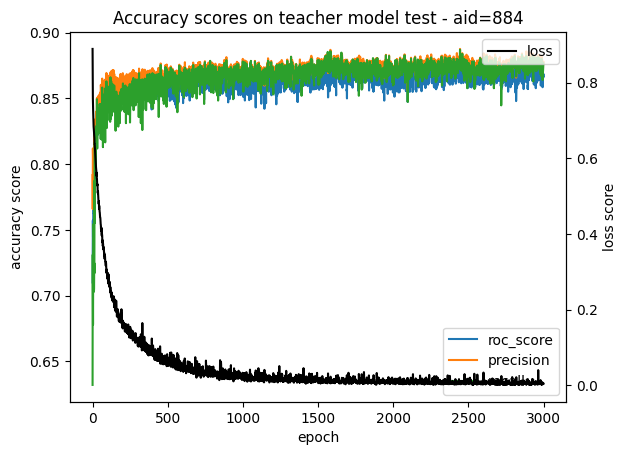

In [19]:
# determine storage location of csv
file_path = csv_path + "teacher-acc_aid={}_epochs={}.csv".format(aid, epochs)

# determine storage location of image
file_path_plot = graphs_path + "TeacherAccs_aid-{}_epochs-{}.png".format(aid, epochs)

# load the csv
loaded_csv = pd.read_csv(file_path, index_col="epoch")

# plotting
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(loaded_csv.roc_score, label="roc_score")
ax1.plot(loaded_csv.precision, label="precision")
ax1.plot(loaded_csv.recall, label="recall")
ax2.plot(loaded_csv.loss, color="black", label="loss")

ax1.set_xlabel("epoch")
ax1.set_ylabel("accuracy score")
ax2.set_ylabel("loss score")
ax1.legend()
ax2.legend()
plt.title("Accuracy scores on teacher model test - aid={}".format(aid))
plt.savefig(file_path_plot, bbox_inches='tight')
plt.show()